<a href="https://colab.research.google.com/github/WildArcher/Master_work/blob/master/News_from_Evgeniy%2Btext_cleaning_from_Alexey(28.07-14.08).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Новости добыты, теперь нужно их разметить

In [1]:
import re
import pandas as pd
import datetime
import time
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tt
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer as CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier as rand_for_clf
from sklearn.metrics import accuracy_score, roc_auc_score

In [30]:
news = pd.read_csv('https://raw.githubusercontent.com/WildArcher/Master_work/master/news_2019-2020_sber_from_interfax.csv').drop(columns=['Unnamed: 0'])

In [31]:
news.head()

,text,header,day_of_week,day,month,year,minute,hour,target
0,"в россии выдано льготной ипотеки под 6,5% на ...","в россии выдано льготной ипотеки под 6,5% на 2...",Wed,2,Jul,2020,57,10,0
1,"сбербанк закрыл сделку по выкупу доли ""ßндекс...","сбербанк закрыл сделку по выкупу доли ""ßндекса...",Wed,2,Jul,2020,38,0,1
2,рынок акций рф во вторник вырос вслед за миро...,рынок акций рф во вторник вырос вслед за миром...,Tue,2,Jul,2020,17,19,1
3,рынок акций рф открылся ростом индексов мосби...,рынок акций рф открылся ростом индексов мосбир...,Tue,2,Jul,2020,35,10,1
4,"сбербанк выдал группе ""аэрофлот"" кредиты на 1...","сбербанк выдал группе ""аэрофлот"" кредиты на 1,...",Tue,2,Jul,2020,42,9,1
...,...,...,...,...,...,...,...,...,...
506,"en+ выкупит у втб 21,37% своих акций за $1,58...","en+ выкупит у втб 21,37% своих акций за $1,58 ...",Thu,6,Feb,2020,48,15,0
507,правительство и цб договорились о постоянных ...,правительство и цб договорились о постоянных к...,Wed,5,Feb,2020,10,17,1
508,"минэкономразвития запросило банки, как они мо...","минэкономразвития запросило банки, как они мог...",Wed,5,Feb,2020,22,12,0
509,государственно-частные партнерства выведут из...,государственно-частные партнерства выведут из-...,Wed,5,Feb,2020,58,9,0


## Возьмем котировки с финам с периодичностью 5 минут и час, чтобы отследить влияние новостей

In [5]:
def preprocessing_sber_data(sber):
  sber.columns=['date', 'time', 'open', 'high', 'low', 'close', 'vol']
  sber.time /= 10_000

  year, month, day = [], [], []
  for i in range(sber.shape[0]):
    year.append(time.strptime(str(sber.date[i]), '%Y%m%d')[0])
    month.append(time.strptime(str(sber.date[i]), '%Y%m%d')[1])
    day.append(time.strptime(str(sber.date[i]), '%Y%m%d')[2])

  sber['year'] = year
  sber['month'] = month
  sber['day'] = day

  #sber.drop(columns=['date'], inplace=True)

  return sber

sber_hour = preprocessing_sber_data(pd.read_csv('https://raw.githubusercontent.com/WildArcher/Master_work/master/SBER_17.07.2019-2020_1hour.csv?', sep=' '))

sber_5_min = preprocessing_sber_data(pd.read_csv('https://raw.githubusercontent.com/WildArcher/Master_work/master/SBER_17.07.2019-2020_5min.csv?', sep=' '))

In [6]:
sber_5_min.head()

,date,time,open,high,low,close,vol,year,month,day
0,20190717,10.05,234.32,237.00,234.02,236.96,1691860,2019,7,17
1,20190717,10.10,236.98,238.04,236.03,236.40,1802480,2019,7,17
2,20190717,10.15,236.40,236.71,235.83,235.96,780150,2019,7,17
3,20190717,10.20,235.96,236.13,235.38,235.91,590180,2019,7,17
4,20190717,10.25,235.91,236.55,235.81,236.41,543260,2019,7,17


In [7]:
date = []
for i in range(sber_5_min.shape[0]):
  date.append(datetime.datetime(sber_5_min.year[i], sber_5_min.month[i], sber_5_min.day[i], int(sber_5_min.time[i] // 1), int((sber_5_min.time[i] % 1)*101)))#

sber_5_min['date'] = date

date = []
for i in range(sber_hour.shape[0]):
  date.append(datetime.datetime(sber_hour.year[i], sber_hour.month[i], sber_hour.day[i], int(sber_hour.time[i] // 1)))

sber_hour['date'] = date

In [8]:
sber_hour['date'] = pd.to_datetime(sber_hour.date)

sber_5_min['date'] = pd.to_datetime(sber_5_min.date)

In [10]:
sber_hour.head()

,date,time,open,high,low,close,vol,year,month,day
0,2019-07-17 11:00:00,11.0,234.32,238.04,234.02,237.12,8548250,2019,7,17
1,2019-07-17 12:00:00,12.0,237.12,237.43,236.55,237.20,2801380,2019,7,17
2,2019-07-17 13:00:00,13.0,237.20,237.20,236.81,237.18,2097860,2019,7,17
3,2019-07-17 14:00:00,14.0,237.17,237.70,236.70,237.19,2848650,2019,7,17
4,2019-07-17 15:00:00,15.0,237.19,237.58,236.85,237.13,1454710,2019,7,17


In [11]:
news.replace(to_replace=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], value=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], inplace=True)
news.drop(columns=['day_of_week'], inplace=True)

In [12]:
date = []
for i in range(news.shape[0]):
  date.append(datetime.datetime(news.year[i], news.month[i], news.day[i], news.hour[i], news.minute[i]))

news['date'] = date

In [13]:
news.head()

,text,header,day,month,year,minute,hour,target,date
0,"в россии выдано льготной ипотеки под 6,5% на ...","в россии выдано льготной ипотеки под 6,5% на 2...",2,7,2020,57,10,0,2020-07-02 10:57:00
1,"сбербанк закрыл сделку по выкупу доли ""ßндекс...","сбербанк закрыл сделку по выкупу доли ""ßндекса...",2,7,2020,38,0,1,2020-07-02 00:38:00
2,рынок акций рф во вторник вырос вслед за миро...,рынок акций рф во вторник вырос вслед за миром...,2,7,2020,17,19,1,2020-07-02 19:17:00
3,рынок акций рф открылся ростом индексов мосби...,рынок акций рф открылся ростом индексов мосбир...,2,7,2020,35,10,1,2020-07-02 10:35:00
4,"сбербанк выдал группе ""аэрофлот"" кредиты на 1...","сбербанк выдал группе ""аэрофлот"" кредиты на 1,...",2,7,2020,42,9,1,2020-07-02 09:42:00


In [14]:
sber_hour['date_int'] = np.zeros(sber_hour.shape[0])

for i in range(sber_hour.shape[0]):
  sber_hour['date_int'][i] = int(sber_hour.date[i].year)*10_000 + int(sber_hour.date[i].month)*100 + int(sber_hour.date[i].day) + sber_hour.date[i].hour/100

news['date_int'] = np.zeros(news.shape[0])

for i in range(news.shape[0]):
  news['date_int'][i] = int(news.date[i].year)*10_000 + int(news.date[i].month)*100 + int(news.date[i].day) + news.date[i].hour/100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
news = news.merge(sber_hour.drop(columns=['date']))

In [16]:
news['target'] = np.where(news.close.shift(-1) > news.close, 1, 0)

# Протестируем небольшой датасет 

In [17]:
df = news[['text', 'header', 'target']]
print('итого из одного источника за год ', df.replace(0, np.nan).dropna().shape[0], 'полезных новостей')
# для обучения и теста это очень мало, но для построения бейзлайна вполне сойдет, сейчас я сделаю модель, которую хоть как-то нужно затестить, а потом соберу нормальные данные

итого из одного источника за год  42 полезных новостей


In [19]:
df.head()

,text,header,target
0,рынок акций рф во вторник вырос вслед за миро...,рынок акций рф во вторник вырос вслед за миром...,0
1,рынок акций начал неделю с роста выше 2800п п...,рынок акций начал неделю с роста выше 2800п по...,0
2,рынок акций рф во вторник вырос вслед за миро...,рынок акций рф во вторник вырос вслед за миром...,0
3,рынок акций начал неделю с роста выше 2800п п...,рынок акций начал неделю с роста выше 2800п по...,0
4,"минфин ждет от сбербанка, ""транснефти"" и втб ...","минфин ждет от сбербанка, ""транснефти"" и втб п...",0
...,...,...,...
192,отскок рынка акций рф сменился новой волной п...,отскок рынка акций рф сменился новой волной па...,1
193,попытка рынка акций подрасти завершились расп...,попытка рынка акций подрасти завершились распр...,1
194,"en+ выкупит у втб 21,37% своих акций за $1,58...","en+ выкупит у втб 21,37% своих акций за $1,58 ...",1
195,правительство и цб договорились о постоянных ...,правительство и цб договорились о постоянных к...,0


In [20]:
# для начала посмотрю, можно ли решить задачу простыми способами без лишни наворочек
count_vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=1000)
X = count_vectorizer.fit_transform(df.text)

In [21]:
train_data, test_data, train_target, test_target = tt (X, df.target, test_size=0.2)
log_reg = LogisticRegression()
xgb_clf = XGBClassifier()
svc = SVC(kernel='rbf')

xgb_clf.fit(train_data, train_target)
log_reg.fit(train_data, train_target)
svc.fit(train_data, train_target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


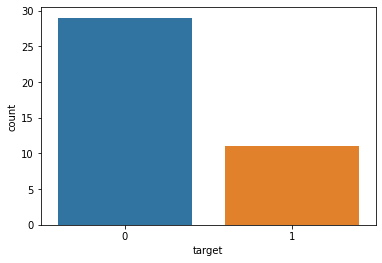

In [22]:
sns.countplot(test_target)

In [23]:
accuracy_score(test_target, xgb_clf.predict(test_data))
#roc_auc_score(test_target, xgb_clf.predict(test_data))

0.725

In [24]:
accuracy_score(test_target, log_reg.predict(test_data))

0.725

In [25]:
accuracy_score(test_target, svc.predict(test_data))

0.725

In [26]:
log_reg.predict(test_data)

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=4000)
X = vectorizer.fit_transform(df.text)
train_data, test_data, train_target, test_target = tt (X, df.target, test_size=0.25)

log_reg.fit(train_data, train_target)
 
accuracy_score(test_target, log_reg.predict(test_data))

0.78

## Новостей мало, нужен большой датасет

##News from Evgeniy

In [1]:
! pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 10.0MB/s 
     |████████████████████████████████| 890kB 30.8MB/s 
     |████████████████████████████████| 1.1MB 42.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=9abbdc9786fa824cd79ddea982082c805007e6fe6200399eb165c86d106eac4d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install pymorphy2

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 7.1MB 6.3MB/s 


In [236]:
import datetime
import time
import re
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
import pickle
from lightgbm import LGBMClassifier
from keras.layers import Activation, Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from keras import Sequential
from collections import Counter
from tensorflow.keras import utils

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, log_loss

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import train_test_split as tt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
import torch
import transformers as ppb
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.sequence import pad_sequences
import pymorphy2

In [170]:
forbes = pd.read_json('interfax.json')

forbes.drop(columns=['url', 'inns'], inplace=True)

In [171]:
date = []

for i in range(forbes.shape[0]):
  date.append(datetime.datetime(year=int(forbes.dttm_published[i][:4]), month=int(forbes.dttm_published[i][5:7]), day=int(forbes.dttm_published[i][8:10])))
  
forbes['date'] = date
forbes.drop(columns=['dttm_published'], inplace=True)

## Text prerocessing

In [172]:
nltk.download('stopwords') # стоп слова русского языка

stop_words = stopwords.words(('russian'))

stop_words.remove('нет')
stop_words.remove('не')
stop_words.remove('ни')

for i in range(len(stop_words)):
 stop_words[i] = ' '+stop_words[i]+' '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
#dictionary = [] # словарь символов, из которых состоят все тексты

#for text in forbes.text.values:
#  text.lower()
#  for char in text:
#    if char not in dictionary:
#      dictionary.append(char)

#dictionary.sort()
#useful_char = [' ']
#useful_char = useful_char + dictionary[34:60] + dictionary[66:92] + dictionary[99:-4]# полезные символы лишь символы алфавита и некоторые другие 
# (взяты по интуитивным соображениям)
# тем самым отбрасываем пунктуацию, цифры и их производные(номера телефонов, договоров) и прочую информацию, которая похожа на шум и не несет в себе смысл

#useless_char = []

#for char in dictionary:
#  if char not in useful_char:
#    useless_char.append(char)

In [175]:
morph = pymorphy2.MorphAnalyzer()

In [209]:
def tex_preprocessing(lemmatize, replacement, del_stop_words, no_connection, del_word_less_2_symbol):

  data = []

  for i in range(forbes.shape[0]):

    d = forbes.text[i]
    d = d.lower() # приведение к нижнему регистру
    d = re.sub(r'https://[a-z1-9./]+', ' ', d) # удаление ссылок

    d = re.sub('[^a-z0-9а-я]', ' ', d) # удаление символов кроме символов русского и английского алфавитов

    if lemmatize == True:
      d = " ".join(morph.parse(word)[0].normal_form for word in d.split()) # Лемматизация

    d = re.sub(' нет ', ' не ', d) # Замена 'нет' и 'ни' на 'не'
    d = re.sub(' ни ', ' не ', d)
    d = re.sub(r'\d+', 'number_token', d) # Замена чисел на number_token

    if replacement == True:
      d = re.sub('ё', 'е', d)
      d = re.sub('й', 'и', d)

    if del_stop_words == True:
      for stop_word in stop_words:
        if stop_word in d:
          d = re.sub(stop_word, ' ', d) # удаление стоп слов      

    if no_connection == True:
      words = d.split()
      for i in range(len(words)-1):
          if words[i] == ' не ':
            words[i] = words[i] + words[i+1]
            words[i+1] = ' '
          else:
            d = ' '.join(words)
            d = ' '.join(d.split())

    if del_word_less_2_symbol == True:
      d = " ".join([w for w in d.split() if len(w) > 2])

    data.append(d)

  return data

In [210]:
data = tex_preprocessing(lemmatize=True, replacement=True, del_stop_words=True, no_connection=True, del_word_less_2_symbol=True)

In [211]:
data[0]

'москва компания infor media russia пятница number_token март провести онлаин конференция закупка секрет данныи момент мир наш страна частность сложиться ситуация которыи работать многие проверить механизм инструмент отмечаться материал компания приходиться адаптироваться реалия искать нестандартныи решение развитие бизнес пробовать новое метод которыи помочь оптимизировать процесс наладить работа существенныи потеря ход конференция планироваться обсудить частность вопрос влияние новыи фактор закупочныи деятельность влияние новыи экономическии социальныи аспект построение внешнии внутреннии взаимодеиствие компания речь идти частность переход закупочныи подразделение удаленныи работа изменение схема работа иностранныи поставщик работа валютныи контракт плата приглашать присоединиться открытыи онлаин диалог эксперт закупка вместе попытаться наити ответ другои вопрос рассмотреть ситуация сеичас вывод делать рано пробовать смелыи нестандартныи решение самыи время сообщать компания данные к

In [26]:
#cnt = Counter() # подсчет числа вхождений каждого слова в текст
#for text in data:
#    for word in str(text).split():
#        cnt[word] += 1
        
#most_frequient = cnt.most_common()

#most_and_less_frequient_words = set([w for (w, wc) in most_frequient[:250] +  most_frequient[-19_770:]]) # -13_005:

#def remove_words(text):

#    return ' '.join([word for word in str(text).split() if word not in most_and_less_frequient_words])

#data = pd.Series(data).apply(lambda text: remove_words(text)) # удаление самых частых и самых редких слов (остались только слова с частотой от 3 до 233)

## Simple test

In [213]:
def preprocessing_sber_data(sber):
  sber.columns=['date', 'time', 'open', 'high', 'low', 'close', 'vol']
  sber.time /= 10_000

  year, month, day = [], [], []
  for i in range(sber.shape[0]):
    year.append(time.strptime(str(sber.date[i]), '%Y%m%d')[0])
    month.append(time.strptime(str(sber.date[i]), '%Y%m%d')[1])
    day.append(time.strptime(str(sber.date[i]), '%Y%m%d')[2])

  sber['year'] = year
  sber['month'] = month
  sber['day'] = day

  sber.drop(columns=['date'], inplace=True)

  return sber

In [214]:
sber_day = preprocessing_sber_data(pd.read_csv('https://raw.githubusercontent.com/WildArcher/Stock_price_prediction/master/sber_data/SBER_2000-2020_day.csv', sep=' '))

In [215]:
sber_day['date'] = np.zeros(sber_day.shape[0])

for i in range(sber_day.shape[0]): 
  sber_day['date'][i] = datetime.datetime(sber_day.year[i], sber_day.month[i], sber_day.day[i])

In [216]:
sber_day.head()

,time,open,high,low,close,vol,year,month,day,date
0,0.0,1333.00,1372.00,1333.0,1352.00,8732,2000,7,17,2000-07-17 00:00:00
1,0.0,1341.17,1352.50,1327.0,1335.00,7134,2000,7,18,2000-07-18 00:00:00
2,0.0,1340.00,1345.49,1282.0,1296.00,18491,2000,7,19,2000-07-19 00:00:00
3,0.0,1293.83,1299.99,1260.0,1284.98,9710,2000,7,20,2000-07-20 00:00:00
4,0.0,1320.00,1330.00,1287.0,1295.00,10973,2000,7,21,2000-07-21 00:00:00


In [218]:
forbes['text'] = data

In [219]:
sber_day['date_int'] = np.zeros(sber_day.shape[0])

for i in range(sber_day.shape[0]):
  sber_day['date_int'][i] = int(sber_day.date[i].year)*10_000 + int(sber_day.date[i].month)*100 + int(sber_day.date[i].day)

In [220]:
forbes['date_int'] = np.zeros(forbes.shape[0])

for i in range(forbes.shape[0]):
  forbes['date_int'][i] = int(forbes.date[i].year)*10_000 + int(forbes.date[i].month)*100 + int(forbes.date[i].day)

In [221]:
forbes = forbes.merge(sber_day.drop(columns=['date']))

forbes['target']  = np.where(forbes.close.shift(-1) > forbes.close, 1, 0)

for i in range(len(np.unique(forbes.date_int))):
  if forbes.target[forbes.date_int == np.unique(forbes.date_int)[i]].mean() != 0:
    for index in forbes.target[forbes.date_int == np.unique(forbes.date_int)[i]].index:
      forbes.target[index] = 1

data = forbes[['close', 'text', 'target']]

In [227]:
def vectorizer(text, tf_idf, ngram_range, max_features, min_df, max_df):

  if tf_idf == True:
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features, min_df=min_df, max_df=max_df)
  else:
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features, min_df=min_df, max_df=max_df)

  X = vectorizer.fit_transform(text)

  return X

In [228]:
vectorized_text = vectorizer(text=data.text, tf_idf=True, ngram_range=(1, 3), max_features=4000, min_df=4, max_df=10000)

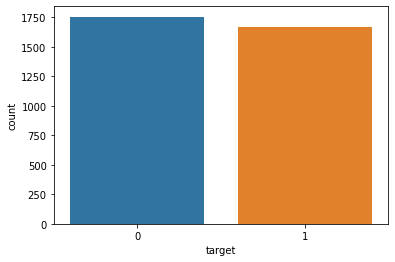

In [233]:
sns.countplot(data.target)
# Баланс классов в норме

In [229]:
train_data, test_data, train_target, test_target = tt (vectorized_text, data.target, test_size=0.2)

xgb_clf = XGBClassifier()
log_reg = LogisticRegression()
rand_for_clf = RandomForestClassifier()
svc = SVC()
neural_net = MLPClassifier(solver='adam', alpha=0.0001, learning_rate='constant', learning_rate_init=0.001)
gauss = GaussianNB()
knn = KNeighborsClassifier()

In [230]:
for model in [xgb_clf, log_reg, rand_for_clf, svc, neural_net, knn]:
  
  model.fit(train_data, train_target)
  print(str(model).split('(')[0], accuracy_score(test_target, model.predict(test_data)), '\n')

XGBClassifier 0.583941605839416 

LogisticRegression 0.6335766423357664 

RandomForestClassifier 0.6423357664233577 

SVC 0.6394160583941606 

MLPClassifier 0.6087591240875913 

KNeighborsClassifier 0.5985401459854015 



In [234]:
rand_for_clf.predict(test_data)
# Предсказания тоже в порядке

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,

In [247]:
metrics = pd.DataFrame(index=[[str(model).split('(')[0] for model in [xgb_clf, log_reg, rand_for_clf, svc, neural_net, knn]]], columns=['accuracy', 'roc_auc', 'f1', 'precision', 'recall', 'log'])

for model in [xgb_clf, log_reg, rand_for_clf, svc, neural_net, knn]:
  
  model.fit(train_data, train_target)

  metrics.accuracy[str(model).split('(')[0]] = accuracy_score(test_target, model.predict(test_data))
  metrics.roc_auc[str(model).split('(')[0]] = roc_auc_score(test_target, model.predict(test_data))
  metrics.f1[str(model).split('(')[0]] = f1_score(test_target, model.predict(test_data))
  metrics.precision[str(model).split('(')[0]] = precision_score(test_target, model.predict(test_data))
  metrics.recall[str(model).split('(')[0]] = recall_score(test_target, model.predict(test_data))
  metrics.log[str(model).split('(')[0]] = log_loss(test_target, model.predict(test_data))

In [248]:
metrics

,accuracy,roc_auc,f1,precision,recall,log
XGBClassifier,0.583942,0.581508,0.545455,0.573826,0.519757,14.3703
LogisticRegression,0.633577,0.631911,0.607199,0.625806,0.589666,12.6559
RandomForestClassifier,0.636496,0.63472,0.609105,0.62987,0.589666,12.5551
SVC,0.639416,0.637875,0.614665,0.63141,0.598784,12.4543
MLPClassifier,0.59854,0.598204,0.585219,0.580838,0.589666,13.8661
KNeighborsClassifier,0.59854,0.597166,0.573643,0.585443,0.56231,13.8661


# BERT

In [249]:
data.head()

,close,text,target
0,188.08,москва компания infor media russia пятница num...,1
1,188.08,москва number_token март интерфакс туризм росс...,1
2,188.08,южныи сахалинск number_token март интерфакс да...,1
3,188.08,тюмень number_token март интерфакс урал аэропо...,1
4,188.08,индия остаться клиент туроператор весь работат...,1


In [250]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [251]:
for i in range(data.shape[0]): # проблема - слишком длинные новости, ее длина в среднем 2000, а для токенайзера максимум 512
# Решение - разбивать на куски длиной не более 512 (конец - конец предложения) и тональность самой новости считать как среднее из тональностей ее составляющих
   data['text'][i] =  data['text'][i][:128]

In [252]:
tokenized = data['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [253]:
tokenized

0       [101, 1191, 14150, 29747, 23925, 25529, 10260,...
1       [101, 1191, 14150, 29747, 23925, 25529, 10260,...
2       [101, 1209, 29743, 18947, 29113, 10325, 1196, ...
3       [101, 1197, 29757, 29745, 15290, 18947, 23742,...
4       [101, 1188, 18947, 29742, 23483, 1193, 29747, ...
                              ...                        
3420    [101, 1195, 14150, 29747, 29747, 23483, 1196, ...
3421    [101, 1189, 16856, 10260, 29747, 18947, 14150,...
3422    [101, 1191, 10325, 18947, 29747, 23925, 1196, ...
3423    [101, 1183, 15290, 14150, 29746, 14150, 29436,...
3424    [101, 4013, 19648, 1184, 14150, 29752, 15290, ...
Name: text, Length: 3425, dtype: object

In [254]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [255]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(3425, 116)

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
train_features, test_features, train_target, test_target = tt(features, data['target'], random_state=42)
  
for model in [xgb_clf, log_reg, rand_for_clf, svc, neural_net, knn]:
  model.fit(train_features, train_target)
  print(str(model).split('(')[0], accuracy_score(test_target, model.predict(test_features)), '\n')